In [90]:
## Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

## Optimize for Jupyter Notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Make dataframes display nicer.
pd.set_option('display.max_columns', None)

## Read the data into a dataframe and display it to make sure it read in correctly.
data = pd.read_csv('cepheid_data.txt', sep='\s*,\s*', header=0,engine='python')
data.head()

,#Name,Period(days),Distance(kpc),V(mag),J(mag),H(mag),K(mag),E(mag),Z([Fe/H])
0,AA Gem,11.302,5.325,9.72,7.646,7.189,7.086,0.345,-0.08
1,AA Mon,3.938,4.710,12.74,9.729,9.186,8.989,0.765,-0.12
2,AB Cam,5.788,6.743,11.86,9.418,8.936,8.746,0.622,-0.11
3,AC Mon,8.014,3.719,10.10,7.579,7.054,6.885,0.507,-0.06
4,AD Cam,11.261,5.325,12.56,8.988,8.363,8.109,0.873,-0.28


In [91]:
## Store the data as a numpy array for easy access.
name = data['#Name']
period = np.array(data['Period(days)'])
distance = np.array(data['Distance(kpc)'])
V_mag = np.array(data['V(mag)'])
J_mag = np.array(data['J(mag)'])
H_mag = np.array(data['H(mag)'])
K_mag = np.array(data['K(mag)'])
excess = np.array(data['E(mag)'])
Z = np.array(data['Z([Fe/H])'])

# Calculate the Absolute Magnitude in Each Band

The absolute magnitude of each observation is calculated by the following relationship. 

$M_{\lambda}= - (-m_{\lambda} - 5 \log d-5+A_{\lambda})$

$A_{\lambda}$ is given by:

$A_{\lambda} = R_V * E_{B-V} * A_{coeff}$

Where $R_V \equiv 3.1$ and $A_{coeff}$ varies based on the photometric band:

\begin{array}{|ccc|}
\hline \text { Band } & A_{coeff} \\
\hline \mathrm{V} & 1 \\
\mathrm{J} & 0.271 \\
\mathrm{H} & 0.175 \\
\mathrm{K} & 0.117 \\
\hline
\end{array}

This leads to the simplified definition of the absolute magnitude:

$M_{\lambda}= - (-m_{\lambda} - 5 \log d-5+R_V * E_{B-V} * A_{coeff})$

In [92]:
R_v = 3.1

A_v = R_v * excess

A_coeff = [1, 0.271, 0.175, 0.117]

A_V_lam = A_v * A_coeff[0]
A_J_lam = A_v * A_coeff[1]
A_H_lam = A_v * A_coeff[2]
A_K_lam = A_v * A_coeff[3]

## Calculate the absolute magnitudes.
M_V = -(-V_mag + 5*np.log10(distance * 1000) - 5 + A_V_lam)
M_J = -(-J_mag + 5*np.log10(distance * 1000) - 5 + A_J_lam)
M_H = -(-H_mag + 5*np.log10(distance * 1000) - 5 + A_H_lam)
M_K = -(-K_mag + 5*np.log10(distance * 1000) - 5 + A_K_lam)

In [93]:
## Define the design matrix
X = np.array((np.log10(period), Z)).T
X = np.c_[np.ones((X.shape[0])), X]

## Define the observation matrix
Y_V = M_V
Y_J = M_J
Y_H = M_H
Y_K = M_K

# Compute least squares minimization to solve for the parameter vector, $\theta$.

Refer to Eq. 11 of Michael Lam's Statistical Modelling II Notes for the derivation of:

$\mathbf{x}^{\dagger} y=\mathbf{x}^{\dagger} \mathbf{X} \boldsymbol{\theta}$

Our goal is to solve this equation for the parameter vector, $\theta$, given a design matrix, x, and an observation matrix, y. 

In [105]:
def least_squares(x, y):
    '''
    Summary:
    Solves the equation X.T * Y = X.T * X * theta

    Parameters
    ----------
    x : design matrix. 
    y : observation matrix.
    '''
    
    ## Compute the RHS
    XT = np.transpose(x)
    XTX = np.matmul(XT, x)
    
    ## Compute the LHS
    XTY = np.matmul(XT, y)
    
    ## Solve for theta.
    coefs = np.linalg.solve(XTX,XTY)
     
    return coefs

# Perform the least squares fit and plot it alongside the observational data.

In [106]:
## Perform least squares for each photometric band.
params_V = least_squares(X,Y_V)
params_J = least_squares(X,Y_J)
params_H = least_squares(X,Y_H)
params_K = least_squares(X,Y_K)

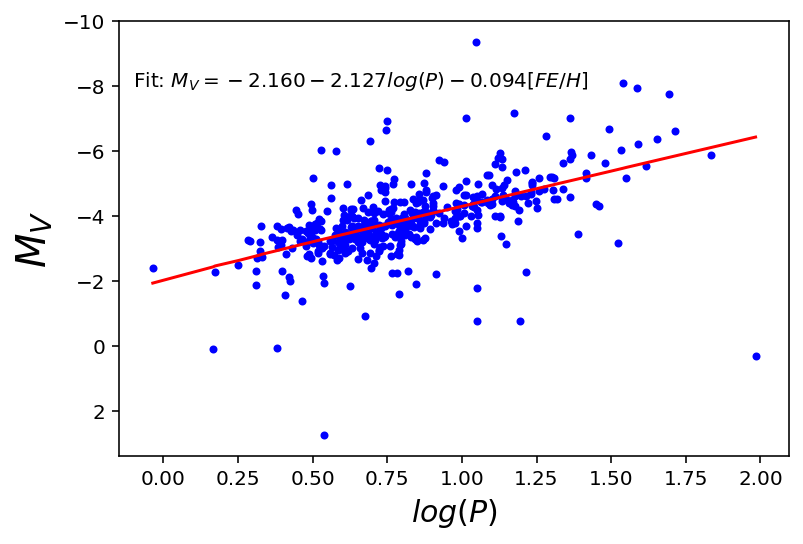

In [107]:
plt.plot(np.log10(np.sort(period)), params_V[0] + params_V[1]*np.log10(np.sort(period)) + params_V[2]*np.sort(Z), color='r')
plt.scatter(np.log10(period), M_V, color='b',marker='.')
plt.xlabel(r'$log(P)$', size=15)
plt.ylabel(r'$M_{V}$', size=20)
plt.text(-0.1,-8,r'Fit: $M_{V} = '+ f'{params_V[0]:2.3f}' + f'{params_V[1]:2.3f}'+'log(P)'+f'{params_V[2]:2.3f}'+'[FE/H]$')
plt.gca().invert_yaxis()

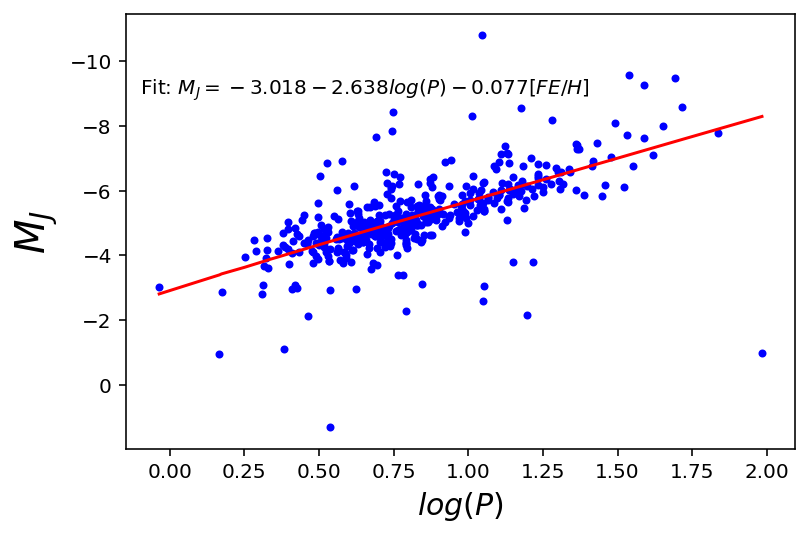

In [108]:
plt.plot(np.log10(np.sort(period)), params_J[0] + params_J[1]*np.log10(np.sort(period)) + params_J[2]*np.sort(Z), color='r')
plt.scatter(np.log10(period), M_J, color='b',marker='.')
plt.xlabel(r'$log(P)$', size=15)
plt.ylabel(r'$M_{J}$', size=20)
plt.text(-0.1,-9,r'Fit: $M_{J} = '+ f'{params_J[0]:2.3f}' + f'{params_J[1]:2.3f}'+'log(P)'+f'{params_J[2]:2.3f}'+'[FE/H]$')
plt.gca().invert_yaxis()

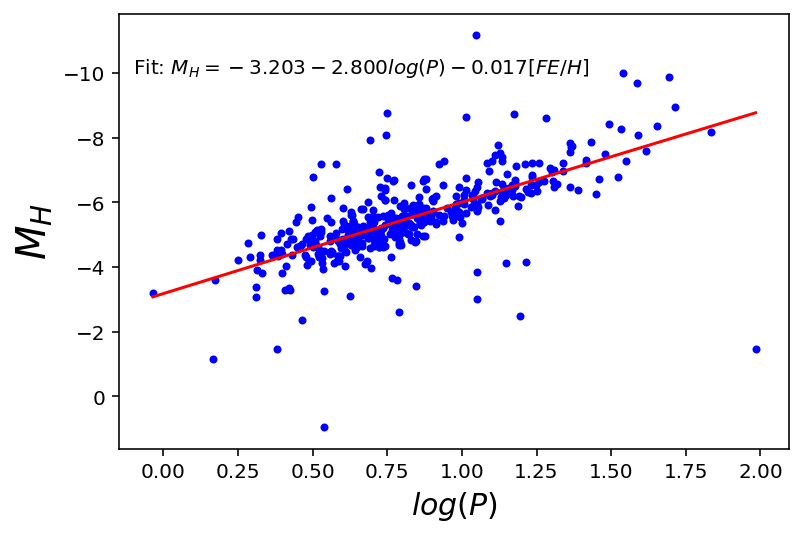

In [109]:
plt.plot(np.log10(np.sort(period)), params_H[0] + params_H[1]*np.log10(np.sort(period)) + params_H[2]*np.sort(Z), color='r')
plt.scatter(np.log10(period), M_H, color='b',marker='.')
plt.xlabel(r'$log(P)$', size=15)
plt.ylabel(r'$M_{H}$', size=20)
plt.text(-0.1,-10,r'Fit: $M_{H} = '+ f'{params_H[0]:2.3f}' + f'{params_H[1]:2.3f}'+'log(P)'+f'{params_H[2]:2.3f}'+'[FE/H]$')
plt.gca().invert_yaxis()

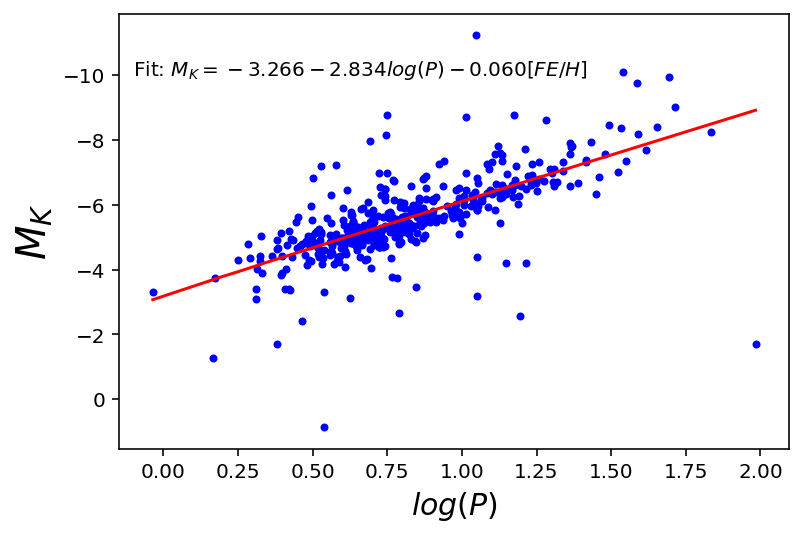

In [110]:
plt.plot(np.log10(np.sort(period)), params_K[0] + params_K[1]*np.log10(np.sort(period)) + params_K[2]*np.sort(Z), color='r')
plt.scatter(np.log10(period), M_K, color='b',marker='.')
plt.xlabel(r'$log(P)$', size=15)
plt.ylabel(r'$M_{K}$', size=20)
plt.text(-0.1,-10,r'Fit: $M_{K} = '+ f'{params_K[0]:2.3f}' + f'{params_K[1]:2.3f}'+'log(P)'+f'{params_K[2]:2.3f}'+'[FE/H]$')
plt.gca().invert_yaxis()

In [100]:
X = np.array((np.log10(period), Z)).T

def uncertanties(alpha, beta, gamma, x, y, period, Z):
    model = alpha + beta*np.log10(period) + gamma*Z
    y_uncert = np.sqrt(1 / (len(y) - 2) * np.sum((y-model)**2))
    delta = len(y) * np.sum(x**2)  - np.sum(x)**2
    alpha_uncert = y_uncert * np.sqrt(np.sum(x**2)/delta)
    beta_uncert = y_uncert * np.sqrt(len(y)/delta)
    gamma_uncert = y_uncert * np.sqrt(len(y)/delta)
    
    return alpha_uncert, beta_uncert, gamma_uncert


In [101]:
print(uncertanties(params_V[0], params_V[1], params_V[2], X, Y_V, period, Z))
print(uncertanties(params_J[0], params_J[1], params_J[2], X, Y_J, period, Z))
print(uncertanties(params_H[0], params_H[1], params_H[2], X, Y_H, period, Z))
print(uncertanties(params_K[0], params_K[1], params_K[2], X, Y_K, period, Z))

(0.14919421800590207, 0.16683799115931466, 0.16683799115931466)
(0.14459907643652187, 0.16169942614805047, 0.16169942614805047)
(0.14266975158107506, 0.15954193849552128, 0.15954193849552128)
(0.14163913651479573, 0.15838944244296135, 0.15838944244296135)


In [102]:
M_V_uncert = -(-V_mag + (np.random.uniform(size=len(V_mag)) - np.random.uniform(size=len(V_mag)))*0.1 + 5*np.log10(distance * 1000) - 5 + A_V_lam)

X_uncert = np.array((np.log10(period), Z)).T
X = np.c_[np.ones((X_uncert.shape[0])), X_uncert]

Y_V_uncert = M_V_uncert

params_V_uncert = least_squares(X,Y_V_uncert)

print(uncertanties(params_V_uncert[0], params_V_uncert[1], params_V_uncert[2], X_uncert, Y_V_uncert, period, Z))

(0.14896826477747035, 0.16658531660374964, 0.16658531660374964)


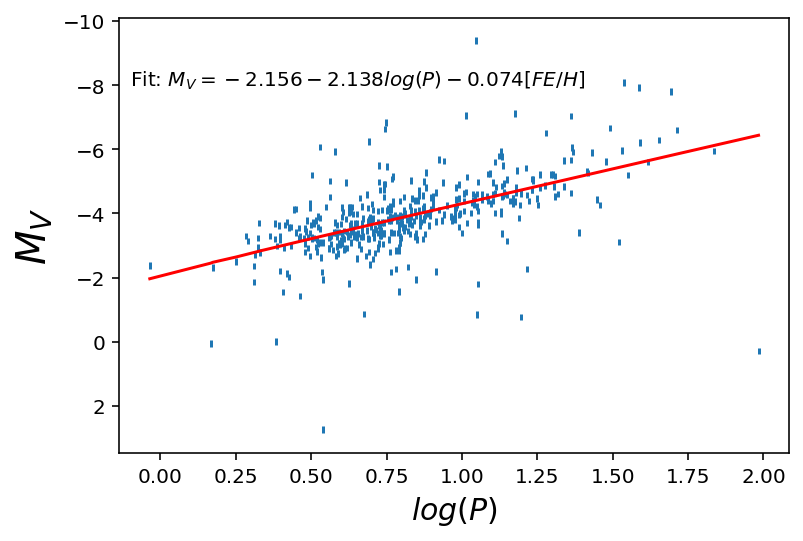

In [103]:
plt.plot(np.log10(np.sort(period)), params_V_uncert[0] + params_V_uncert[1]*np.log10(np.sort(period)) + params_V_uncert[2]*np.sort(Z), color='r')
plt.errorbar(np.log10(period), M_V_uncert, yerr = 0.1,marker='.',ls='none',fmt='none')
plt.xlabel(r'$log(P)$', size=15)
plt.ylabel(r'$M_{V}$', size=20)
plt.text(-0.1,-8,r'Fit: $M_{V} = '+ f'{params_V_uncert[0]:2.3f}' + f'{params_V_uncert[1]:2.3f}'+'log(P)'+f'{params_V_uncert[2]:2.3f}'+'[FE/H]$')
plt.gca().invert_yaxis()